# Wikipedia Notable Life Expectancies
# [Notebook 11: Basic Linear Regression Model ](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_modeling_thanak_2022_10_9.ipynb)
### Context

The
### Objective

The
### Data Dictionary
- Feature: Description

### Importing Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
# import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# randomized data splitting
from sklearn.model_selection import train_test_split

# building regression model
import statsmodels.api as sm

# check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# check linear regression assumptions
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

# to compare fit between models
from scipy.stats.distributions import chi2

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 211)

# To set some dataframe visualization attributes
pd.set_option("max_colwidth", 150)

# To supress scientific notations for a dataframe
# pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some plot visualization attributes
sns.set_theme()
sns.set(font_scale=1.4)
sns.set_palette(
    (
        "midnightblue",
        "goldenrod",
        "maroon",
        "darkolivegreen",
        "cadetblue",
        "tab:purple",
        "yellowgreen",
    )
)
# plt.rc("font", size=12)
# plt.rc("axes", titlesize=15)
# plt.rc("axes", labelsize=14)
# plt.rc("xtick", labelsize=13)
# plt.rc("ytick", labelsize=13)
# plt.rc("legend", fontsize=13)
# plt.rc("legend", fontsize=14)
# plt.rc("figure", titlesize=16)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### [Reading](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_preproc.csv), Sampling, and Checking Data Shape

In [2]:
# Reading the train set
data = pd.read_csv("wp_life_expect_preproc.csv")

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 77661 rows and 6 columns.


,age,recip_num_references,region,prior_region,known_for,years
0,73.0,0.250000,Europe,No Prior Region,spiritual,8
1,90.0,0.333333,North America,No Prior Region,two,13


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,age,recip_num_references,region,prior_region,known_for,years
77659,74.0,0.142857,North America,No Prior Region,arts,0
77660,92.0,0.200000,Europe,No Prior Region,sports,8


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,age,recip_num_references,region,prior_region,known_for,years
51126,95.0,0.052632,North America,No Prior Region,politics_govt_law,27
40899,82.0,0.029412,Europe,No Prior Region,arts,28
7034,87.0,0.043478,Europe,No Prior Region,arts,7
8455,86.0,0.083333,North America,No Prior Region,law_enf_military_operator,14
17560,90.0,0.200000,Europe,No Prior Region,arts,27


<IPython.core.display.Javascript object>

### Checking Data Types and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77661 entries, 0 to 77660
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   77661 non-null  float64
 1   recip_num_references  77661 non-null  float64
 2   region                77661 non-null  object 
 3   prior_region          77661 non-null  object 
 4   known_for             77661 non-null  object 
 5   years                 77661 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 3.6+ MB


<IPython.core.display.Javascript object>

#### Observations:
- With our dataset loaded, we are ready for modeling.
- We have two variables that need typcasting from object to category, then one hot encoding.

In [6]:
df["prior_region"].value_counts()

No Prior Region               73352
Europe                         2326
North America                   432
Asia                            341
Russian Federation              279
Africa                          242
Mid-Cent America/Caribbean      202
Middle East                     176
Oceania                         136
South America                   109
South East Asia                  58
Central Asia                      8
Name: prior_region, dtype: int64

<IPython.core.display.Javascript object>

#### Typecasting `prior_region` and `region` as Categorical

In [7]:
# Typcasting prior_region and region as categorical
df[["prior_region", "region"]] = df[["prior_region", "region"]].astype("category")

# Re-check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77661 entries, 0 to 77660
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   77661 non-null  float64 
 1   recip_num_references  77661 non-null  float64 
 2   region                77661 non-null  category
 3   prior_region          77661 non-null  category
 4   known_for             77661 non-null  object  
 5   years                 77661 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(1)
memory usage: 2.5+ MB


<IPython.core.display.Javascript object>

## Building a Linear Regression Model

### Data Preparation for Modeling
As there is no model tuning in this basic linear regression model, we can train directly with the `train` set and check performance direclty on the `test` set.  We will need to do the appropriate treatments on the `test` set first.

### Test Set

#### Loading [Test Set](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_test.csv) and [region_place_dict](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/region_place_dict.pkl)

In [8]:
# Reading test.csv
test = pd.read_csv("wp_life_expect_test.csv")

# Checking shape
print(f"There are {test.shape[0]} rows and {test.shape[1]} columns.")

# Loading region_place_dict
with open("region_place_dict.pkl", "rb") as f:
    region_place_dict = pickle.load(f)

There are 19608 rows and 25 columns.


<IPython.core.display.Javascript object>

In [9]:
# Checking info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19608 entries, 0 to 19607
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day                        19608 non-null  int64  
 1   name                       19608 non-null  object 
 2   info                       19608 non-null  object 
 3   link                       19608 non-null  object 
 4   num_references             19608 non-null  int64  
 5   year                       19608 non-null  int64  
 6   month                      19608 non-null  object 
 7   info_parenth               6832 non-null   object 
 8   age                        19608 non-null  float64
 9   cause_of_death             6641 non-null   object 
 10  place_1                    19580 non-null  object 
 11  place_2                    1193 non-null   object 
 12  sciences                   19608 non-null  int64  
 13  social                     19608 non-null  int

<IPython.core.display.Javascript object>

#### Pre-processing Steps

In [10]:
%%time

# 1. Dropping non-human entries
rows_to_drop = test[test["other_species"] == 1].index
test.drop(rows_to_drop, inplace=True)
test.reset_index(inplace=True, drop=True)

# 2. Dropping entries with event_record_other as sole category
rows_to_drop = test[(test['event_record_other']==1) & (test['num_categories']==1)].index
test.drop(rows_to_drop, inplace=True)
test.reset_index(inplace=True, drop=True)

# 3. Creating recip_num_references column
test["recip_num_references"] = test["num_references"].apply(lambda x: 1 / x)

# 4. Creating region column
# Dropping place_2 values that are duplicates of place_1
index = [
    index
    for index in test.index
    if test.loc[index, "place_2"] == test.loc[index, "place_1"]
]
test.loc[index, "place_2"] = None

# For loop to create region column
test["region"] = None
for region, places in region_place_dict.items():
    for place in places:
        for index in test[(test["region"].isna()) & (test["place_2"].notna())].index:
            item = test.loc[index, "place_2"]
            if item:
                if item == place:
                    test.loc[index, "region"] = region
        for index in test[(test["region"].isna()) & (test["place_2"].isna())].index:
            item = test.loc[index, "place_1"]
            if item:
                if item == place:
                    test.loc[index, "region"] = region

# 5. Creating prior_region column
# For loop to create prior_region column
test["prior_region"] = None
for region, places in region_place_dict.items():
    for place in places:
        for index in test[
            (test["place_2"].notna()) & (test["prior_region"].isna())
        ].index:
            item = test.loc[index, "place_1"]
            if item:
                if item == place:
                    test.loc[index, "prior_region"] = region
# Adding No Prior Region category
test["prior_region"].fillna("No Prior Region", inplace=True)

# 6. Creating known_for column
# Initializing known_for
test['known_for']=None
# List of known for columns
cols = ['sciences', 'social', 'spiritual', 'academia_humanities',
       'business_farming', 'arts', 'sports', 'law_enf_military_operator',
       'politics_govt_law', 'crime', 'event_record_other', 'other_species']
# For loop to assign known_for
for index in test[test['known_for'].isna()].index:
    if test.loc[index, 'num_categories']==2:
        test.loc[index, 'known_for'] = 'two'
    elif test.loc[index, 'num_categories'] > 2:
        test.loc[index, 'known_for'] = 'three_to_five'
    else: 
        for column in cols:
            if test.loc[index, column]==1:
                test.loc[index, 'known_for'] = column

# 7. Creating years column
test["years"] = test["year"].apply(lambda x: x - 1994)

# 8. Typecasting object columns as category
test[['region', 'prior_region', 'known_for']] = test[['region', 'prior_region', 'known_for']].astype('category')

# 9. Dropping Unnecessary Columns
cols_to_drop = [
   'day', 'name', 'info', 'link', 'num_references', 'year', 'month',
       'info_parenth', 'cause_of_death', 'place_1', 'place_2',
       'sciences', 'social', 'spiritual', 'academia_humanities',
       'business_farming', 'arts', 'sports', 'law_enf_military_operator',
       'politics_govt_law', 'crime', 'event_record_other', 'other_species',
       'num_categories', 
]
test.drop(cols_to_drop, axis=1, inplace=True)

# Rechecking columns
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   19430 non-null  float64 
 1   recip_num_references  19430 non-null  float64 
 2   region                19410 non-null  category
 3   prior_region          19430 non-null  category
 4   known_for             19430 non-null  category
 5   years                 19430 non-null  int64   
dtypes: category(3), float64(2), int64(1)
memory usage: 513.6 KB
CPU times: total: 10.7 s
Wall time: 10.8 s


<IPython.core.display.Javascript object>

In [11]:
# Checking a sample of rows
test.sample(5)

,age,recip_num_references,region,prior_region,known_for,years
13775,83.0,0.250000,North America,No Prior Region,arts,23
8446,88.0,0.333333,Europe,No Prior Region,arts,14
9485,81.0,0.250000,North America,No Prior Region,sports,21
3693,84.0,0.250000,North America,No Prior Region,arts,23
18198,94.0,0.250000,Europe,No Prior Region,two,3


<IPython.core.display.Javascript object>

#### Observations:
- Treatment of `test` missing values is the only remaining step.
- We will use the modes for the `known_for` groups from `train` to fill missing values for `test` to avoid data leakage.  `region` is the only column with missing values.

#### Treating Missing Values for `region` in Test

In [12]:
# Checking the starting missing values
print(f'There are {test["region"].isna().sum()} missing values.')

There are 20 missing values.


<IPython.core.display.Javascript object>

In [13]:
# For loop to impute test missing values with mode of train rows with matching sole known for category
for index in test[test["region"].isna()].index:
    value = test.loc[index, "known_for"]
    group_mode = df[df["known_for"] == value]["region"].mode().iloc[0]
    test.loc[index, "region"] = group_mode

# Checking the starting missing values
print(f'There are {test["region"].isna().sum()} missing values.')

# Checking region value_counts
test["region"].value_counts()

There are 0 missing values.


North America                 8053
Europe                        6136
Asia                          1639
Oceania                        981
Africa                         676
Middle East                    460
South America                  441
Mid-Cent America/Caribbean     389
Russian Federation             325
South East Asia                311
Central Asia                    19
Name: region, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- `train` and `test` are both ready for modeling.
- We will perform one hot encoding when defining our independent variables.

#### Defining Independent and Dependent Variables for Train and Test Sets

In [14]:
# Defining independent and dependent variables
X_train, X_test = df.drop("age", axis=1), test.drop("age", axis=1)
y_train, y_test = df["age"], test["age"]


# One hot encoding independent categorical features
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Adding the intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Typecasting independent variables as float
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")

# Checking shape of train and test sets
print(f"There are {X_train.shape[0]} rows and {X_train.shape[1]} columns in X_train.")
print(f"There are {X_test.shape[0]} rows and {X_test.shape[1]} columns in X_test.\n")

# Checking a sample of train set
X_train.sample(2)

There are 77661 rows and 35 columns in X_train.
There are 19430 rows and 35 columns in X_test.



,const,recip_num_references,years,region_Asia,region_Central Asia,region_Europe,region_Mid-Cent America/Caribbean,region_Middle East,region_North America,region_Oceania,region_Russian Federation,region_South America,region_South East Asia,prior_region_Asia,prior_region_Central Asia,prior_region_Europe,prior_region_Mid-Cent America/Caribbean,prior_region_Middle East,prior_region_No Prior Region,prior_region_North America,prior_region_Oceania,prior_region_Russian Federation,prior_region_South America,prior_region_South East Asia,known_for_arts,known_for_business_farming,known_for_crime,known_for_law_enf_military_operator,known_for_politics_govt_law,known_for_sciences,known_for_social,known_for_spiritual,known_for_sports,known_for_three_to_five,known_for_two
20791,1.0,0.025641,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68796,1.0,0.166667,22.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [15]:
# Checking a sample of test set
X_test.sample(2)

,const,recip_num_references,years,region_Asia,region_Central Asia,region_Europe,region_Mid-Cent America/Caribbean,region_Middle East,region_North America,region_Oceania,region_Russian Federation,region_South America,region_South East Asia,prior_region_Asia,prior_region_Central Asia,prior_region_Europe,prior_region_Mid-Cent America/Caribbean,prior_region_Middle East,prior_region_No Prior Region,prior_region_North America,prior_region_Oceania,prior_region_Russian Federation,prior_region_South America,prior_region_South East Asia,known_for_arts,known_for_business_farming,known_for_crime,known_for_law_enf_military_operator,known_for_politics_govt_law,known_for_sciences,known_for_social,known_for_spiritual,known_for_sports,known_for_three_to_five,known_for_two
7231,1.0,0.090909,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13306,1.0,0.111111,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<IPython.core.display.Javascript object>

#### Observations:
- We are ready to build our model.
- The references levels for the categorical features are as follows:
    - `region`: Africa
    - `prior_region`: Africa
    - `known_for` academia_humanities

### Fitting a Linear Model

In [16]:
# Fitting a linear model and displaying model summary
olsmodel = sm.OLS(y_train, X_train).fit()
print(olsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     241.1
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:13:59   Log-Likelihood:            -3.2105e+05
No. Observations:               77661   AIC:                         6.422e+05
Df Residuals:                   77626   BIC:                         6.425e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>

### Model Performance Check

#### Functions to check model performance

In [17]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs((targets - predictions) / targets)) * 100


# function to compute and display different metrics to check performance of a regression model
# with conversion back to original scale for RMSE, MAE, and MAPE for ease of explainability
def model_performance_regression(model, predictors, target):
    """
    Function to compute and return a dataframe of different metrics to check
    regression model performance
    
    model: regressor
    predictors: independent variables
    target: dependent variable
    """
    # predictions
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

#### Model Performance on Train Set

In [18]:
# Checking model performance on train set
print("Training Performance\n")
olsmodel_train_perf = model_performance_regression(olsmodel, X_train, y_train)
olsmodel_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,15.105332,11.708869,0.095515,0.095107,19.460323


<IPython.core.display.Javascript object>

### Model Performance on Test Set

In [19]:
# Checking model performance on validation set
print("Test Peformance\n")
olsmodel_test_perf = model_performance_regression(olsmodel, X_test, y_test)
olsmodel_test_perf

Test Peformance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,14.991857,11.643245,0.092908,0.091271,19.158569


<IPython.core.display.Javascript object>

#### Observations:
- The train and test $R^2$ are 0.096 and 0.093, respectively, indicating that the model explains 9.6% of total variation in the train set and 9.3% of variation in the test set, so a very small amount.
- RMSE values for the two sets are also comparable.
- The comparable results between the two sets show that the model is not overfitting.
- MAE indicates that our current model is able to predict age of reported deceased notable Wikipedia individuals within a mean error of 11.6 years on the test set.
- MAPE of 19.2% on the test set means that we are able to predict within 19.2% of the reported age, in years.

### Checking Linear Regression Assumptions

### Test for Multicollinearity

#### Function to check VIF of Each Independent Variable

In [20]:
# Define a function to check and display VIF of each independent variable
def checking_vif(predictors):
    """
    Takes input dependent variables predictors and returns
    a dataframe of variable name and VIF
    """
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif

<IPython.core.display.Javascript object>

#### VIF

In [21]:
# Checking vif
vif = checking_vif(X_train).sort_values(by="VIF", ascending=False)
vif

,feature,VIF
0,const,388.159785
18,prior_region_No Prior Region,16.899416
15,prior_region_Europe,10.310942
8,region_North America,7.823522
24,known_for_arts,7.517176
5,region_Europe,7.118230
32,known_for_sports,5.438917
28,known_for_politics_govt_law,5.012830
34,known_for_two,4.467234
3,region_Asia,3.185039


<IPython.core.display.Javascript object>

#### Observations:
- The majority of predictors have low VIF (< 5), which is good.
- We will accept the higher VIF value belonging to the constant as the constant is necessary for the residuals to have zero mean, avoiding bias.
- We will proceed by checking the impact on performance of dropping each of the high VIF columns, and drop the column with the least impact on performance, then re-evaluate VIF.  
- This process is iterative until we have all low VIF columns.

#### Function to Treat Multicollinearity

In [22]:
def treating_multicollinearity(predictors, target, high_vif_columns):
    """
    Checking the effect of dropping the columns showing high multicollinearity
    on model performance (adj. R-squared and RMSE)

    predictors: independent variables
    target: dependent variable
    high_vif_columns: columns having high VIF
    """
    # empty lists to store adj. R-squared and RMSE values
    adj_r2 = []
    rmse = []

    # build ols models by dropping one of the high VIF columns at a time
    # store the adjusted R-squared and RMSE in the lists defined previously
    for cols in high_vif_columns:
        # defining the new train set
        train = predictors.loc[:, ~predictors.columns.str.startswith(cols)]

        # create the model
        olsmodel = sm.OLS(target, train).fit()

        # adding adj. R-squared and RMSE to the lists
        adj_r2.append(olsmodel.rsquared_adj)
        rmse.append(np.sqrt(olsmodel.mse_resid))

    # creating a dataframe for the results
    temp = pd.DataFrame(
        {
            "col": high_vif_columns,
            "Adj. R-squared after_dropping col": adj_r2,
            "RMSE after dropping col": rmse,
        }
    ).sort_values(by="Adj. R-squared after_dropping col", ascending=False)
    temp.reset_index(drop=True, inplace=True)

    return temp

<IPython.core.display.Javascript object>

#### Checking Impact of Dropping Columns on Model Performance

In [23]:
# Checking impact of dropping columns
col_list = vif[vif["VIF"] >= 5]["feature"].tolist()
col_list.remove("const")

results = treating_multicollinearity(X_train, y_train, col_list)
results

,col,Adj. R-squared after_dropping col,RMSE after dropping col
0,prior_region_No Prior Region,0.095026,15.109507
1,known_for_politics_govt_law,0.094436,15.114437
2,prior_region_Europe,0.094418,15.114582
3,known_for_arts,0.091543,15.138561
4,known_for_sports,0.085198,15.191333
5,region_Europe,0.083465,15.205718
6,region_North America,0.082156,15.216568


<IPython.core.display.Javascript object>

#### Observations:
- Of the high VIF columns, `prior_region_No Prior Region` has the least impact on performance when dropped, so we will drop it.

#### Dropping `prior_region_No Prior Region`

In [24]:
# Dropping prior_region_No Prior Region column
col_to_drop = "prior_region_No Prior Region"
X_train = X_train.drop(col_to_drop, axis=1)
X_test = X_test.drop(col_to_drop, axis=1)

# Recheck VIF
vif = checking_vif(X_train).sort_values(by="VIF", ascending=False)
vif

,feature,VIF
0,const,70.554213
8,region_North America,7.820644
23,known_for_arts,7.516880
5,region_Europe,7.117233
31,known_for_sports,5.438910
27,known_for_politics_govt_law,5.012822
33,known_for_two,4.467184
3,region_Asia,3.183439
28,known_for_sciences,2.687217
9,region_Oceania,2.309987


<IPython.core.display.Javascript object>

#### Checking Impact of Dropping Columns on Model Performance

In [25]:
# Checking impact of dropping columns
col_list = vif[vif["VIF"] >= 5]["feature"].tolist()
col_list.remove("const")

results = treating_multicollinearity(X_train, y_train, col_list)
results

,col,Adj. R-squared after_dropping col,RMSE after dropping col
0,known_for_politics_govt_law,0.094343,15.115213
1,known_for_arts,0.091443,15.139394
2,known_for_sports,0.085108,15.192078
3,region_Europe,0.083345,15.206712
4,region_North America,0.082015,15.217740


<IPython.core.display.Javascript object>

#### Observations:
- Of the remaining high VIF columns, `known_for_politics_govt_law` has the least impact on performance when dropped, so we will drop it.

#### Dropping `known_for_politics_govt_law`

In [26]:
# Dropping known_for_politics_govt_law column
col_to_drop = "known_for_politics_govt_law"
X_train = X_train.drop(col_to_drop, axis=1)
X_test = X_test.drop(col_to_drop, axis=1)

# Recheck VIF
vif = checking_vif(X_train).sort_values(by="VIF", ascending=False)
vif

,feature,VIF
0,const,42.022686
8,region_North America,7.798003
5,region_Europe,7.086783
3,region_Asia,3.180452
9,region_Oceania,2.308154
23,known_for_arts,1.862710
7,region_Middle East,1.724744
11,region_South America,1.663567
30,known_for_sports,1.633636
6,region_Mid-Cent America/Caribbean,1.550907


<IPython.core.display.Javascript object>

#### Checking Impact of Dropping Columns on Model Performance

In [27]:
# Checking impact of dropping columns
col_list = vif[vif["VIF"] >= 5]["feature"].tolist()
col_list.remove("const")

results = treating_multicollinearity(X_train, y_train, col_list)
results

,col,Adj. R-squared after_dropping col,RMSE after dropping col
0,region_Europe,0.082234,15.215926
1,region_North America,0.080967,15.226423


<IPython.core.display.Javascript object>

#### Observations:
- That iteration got us down to two remaining high VIF columns.
- Of the remaining high VIF columns, `region_Europe` has the least impact on performance when dropped, so we will drop it.

#### Dropping `region_Europe`

In [28]:
# Dropping region_Europe column
col_to_drop = "region_Europe"
X_train = X_train.drop(col_to_drop, axis=1)
X_test = X_test.drop(col_to_drop, axis=1)

# Recheck VIF
vif = checking_vif(X_train).sort_values(by="VIF", ascending=False)
vif

,feature,VIF
0,const,17.026662
22,known_for_arts,1.847609
29,known_for_sports,1.624539
31,known_for_two,1.487585
7,region_North America,1.308270
26,known_for_sciences,1.253125
3,region_Asia,1.155868
25,known_for_law_enf_military_operator,1.136902
8,region_Oceania,1.093740
28,known_for_spiritual,1.092234


<IPython.core.display.Javascript object>

#### Observations:
- `prior_region_No Prior Region`, `known_for_politics_govt_law`, and `region_Europe` columns were dropped and there are no remaining high VIF columns,excluding the constant, which we will retain.
- **So, the assumption of independence of predictor variables (absence of multicollinearity) is satisfied.**
- The updated reference levels for each feature are as follows:
    - `region`: Africa OR Europe
    - `prior_region`: Africa OR No Prior Region
    - `known_for`: academia_humanities OR politics_govt_law
- Next, we will fit our second model, then drop columns with high p-values for their coefficients.

#### Fitting Second Model

In [29]:
# Fitting a linear model and displaying model summary
olsmodel2 = sm.OLS(y_train, X_train).fit()
print(olsmodel2.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     225.5
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:19:18   Log-Likelihood:            -3.2160e+05
No. Observations:               77661   AIC:                         6.433e+05
Df Residuals:                   77629   BIC:                         6.436e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>

#### Checking Features with High Coefficient p-values

In [30]:
## Loop for Dropping variables with high coefficient p-values one at a time excluding constant and dummy variables
# Current model predictors
train_predictors = X_train

# initial list of all independent variable columns including constant
cols = train_predictors.columns.to_list()

# initial empty list of independent variables to exclude
excluded_features = []

# setting an initial max p_value
max_p_value = 1

for i in range(len(cols)):
    # defining the train set
    x_train_aux = train_predictors[cols]

    # fitting the model
    model = sm.OLS(y_train, x_train_aux).fit()

    # getting the p-values and the maximum p-value
    p_values = model.pvalues[cols]
    max_p_value = max(p_values)

    # name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
        excluded_features.append(feature_with_p_max)
    else:
        break

print(f"Features with high p-values to exclude: {excluded_features}")

Features with high p-values to exclude: ['known_for_social', 'prior_region_Central Asia', 'prior_region_South America', 'prior_region_Mid-Cent America/Caribbean', 'prior_region_Oceania', 'prior_region_North America', 'region_Oceania', 'prior_region_Asia', 'known_for_business_farming']


<IPython.core.display.Javascript object>

#### Dropping `excluded_features` with High p-values

In [31]:
# Dropping excluded_features
X_train.drop(excluded_features, axis=1, inplace=True)
X_test.drop(excluded_features, axis=1, inplace=True)

<IPython.core.display.Javascript object>

#### Observations:
- We dropped several columns with high p-values.
- The updated reference levels for each feature are as follows:
    - `region`: Africa, Europe, OR Oceania
    - `prior_region`: Africa, No Prior Region, Central Asia, South America, Mid-Cent America/Caribbean, Oceania, North America, OR Asia
    - `known_for`: academia_humanities, politics_govt_law, social 

#### Fitting Third Model

In [32]:
# fitting third model and printing summary
olsmodel3 = sm.OLS(y_train, X_train).fit()
print(olsmodel3.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     317.2
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:26:01   Log-Likelihood:            -3.2161e+05
No. Observations:               77661   AIC:                         6.433e+05
Df Residuals:                   77638   BIC:                         6.435e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

<IPython.core.display.Javascript object>

#### Observations:
- Adjusted $R^2$ has held at 0.082 after dropping the high p-value columns, indicating that the dropped variables were not affecting the model much at all.
- **Now, no other feature, including the constant, has a p-value greater than 0.05, so we will consider these features as the final set of predictor variables and *olsmodel3* as the final model.**
- *olsmodel3* has 22 predictors plut the constant term.
- We will now check the remaining assumptions for linear regression.

### Test for Linearity and Independence

#### Dataframe of Actual, Fitted, and Residual Values

In [35]:
# Dataframe of actual, fitted, and residual values
df_pred = pd.DataFrame()

df_pred["Actual Values"] = y_train  # actual values
df_pred["Fitted Values"] = olsmodel3.fittedvalues  # predicted values
df_pred["Residuals"] = olsmodel3.resid  # residuals

df_pred.sample(5)

,Actual Values,Fitted Values,Residuals
65679,92.0,76.908168,15.091832
46579,29.0,67.634527,-38.634527
63886,92.0,79.930321,12.069679
66717,95.0,85.292829,9.707171
3679,67.0,82.799558,-15.799558


<IPython.core.display.Javascript object>

#### Plot of Fitted Values vs Residuals

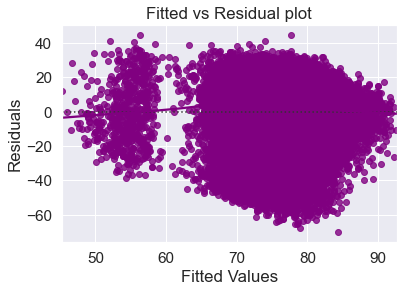

<IPython.core.display.Javascript object>

In [36]:
# Plot of fitted values vs residuals
sns.residplot(
    data=df_pred, x="Fitted Values", y="Residuals", color="purple", lowess=True
)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residual plot")
plt.show()

#### Observation:
- There is an underrepresented age group from ~58 to ~63 years in the predictions, resulting in two groups which is interesting.
- Within itself, the under 60 group shows no obvious pattern.
- The group above 60 is heavy on the bottom, indicating larger underestimates for age here, and wider variance.
- **Overall, there is not a definitive pattern, so we will consider the assumptions of independence and linearity met.**
- We will be testing further for heteroscedastictiy, via the Goldfeld-Quandt test.

### Test for Normality

#### Histogram

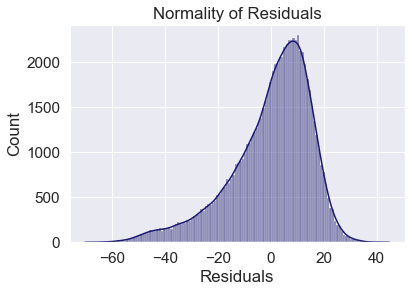

<IPython.core.display.Javascript object>

In [37]:
# Histogram of residuals
sns.histplot(data=df_pred, x="Residuals", kde=True)
plt.title("Normality of Residuals")
plt.show()

#### Q-Q plot

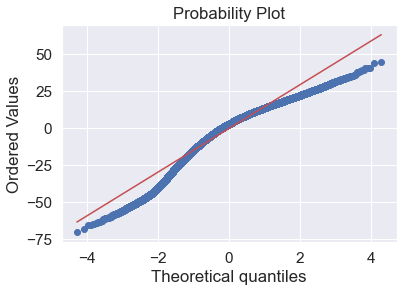

<IPython.core.display.Javascript object>

In [38]:
# checking the Q-Q plot
stats.probplot(df_pred["Residuals"], dist="norm", plot=pylab)
plt.show()

#### Observations:
- The distribution of the residuals does have an overall bell shape, but is quite peaked at ~8, with a thicker tail on the negative end.
- As we saw during EDA, there are possibly two Guassian's here.
- The Q-Q plot and the histogram show that the distribution is left-skewed.
- **We cannot strictly say that the assumption of normally distributed residuals is met.**
- Our plan is to apply other modeling algorithms, so we will see how they compare.

### Test for Homoscedasticity

#### Goldfeld-Quandt Test

In [40]:
# Goldfeld-quandt test
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_pred["Residuals"], X_train)
lzip(name, test)

[('F statistic', 1.0039280571194993), ('p-value', 0.3496943925977429)]

<IPython.core.display.Javascript object>

#### Observations:
- Since p-value is > 0.05, the residuals are homoscedastic.
- **The assumption of homoscedasticity is met.**
- **Not all of the assumptions of linear regression are strictly met.  However, we will accept them as sufficiently met to allow for guarded interpretation in addition to prediction.**

## Final Model Summary

### *olsmodel3* summary

In [41]:
print(olsmodel3.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     317.2
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:10:19   Log-Likelihood:            -3.2161e+05
No. Observations:               77661   AIC:                         6.433e+05
Df Residuals:                   77638   BIC:                         6.435e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

<IPython.core.display.Javascript object>

#### Final Model Performance on Train Set

In [42]:
# Checking final model performance on train set
print("Training Performance\n")
olsmodel_train_perf = model_performance_regression(olsmodel3, X_train, y_train)
olsmodel_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,15.213844,11.7998,0.082473,0.082201,19.63805


<IPython.core.display.Javascript object>

#### Final Model Performance on Validation Set

In [43]:
# Checking final model performance on test set
print("Testing Performance\n")
olsmodel_test_perf = model_performance_regression(olsmodel3, X_test, y_test)
olsmodel_test_perf

Testing Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,15.102388,11.735861,0.079484,0.078393,19.331971


<IPython.core.display.Javascript object>

#### Observations:
- With $R^2$ of only 0.082 on the train set, our model is underfitting.  The predictors are only able to explain ~8% of the variation from the mean actual age.
- Test $R^2$ of 0.079 indicates that the model is not overfitting, as it compares to that of the test set along with other measures.
- MAE of 11.7 suggests that the model can predict within a mean error of 11.7 years on the test data.
- MAPE of 19.3 on the test data means that we aree able to predict within ~19.3% of age.

## Interpreting *olsmodel3* Parameters

In [45]:
# For loop to make list of parameters with p-values < 0.05
# Final model predictors
final_pred = X_train

# initial list of all independent variable columns excluding constant
cols = final_pred.columns[1:]

# initial list of columns to interpret
features_to_interp = []

# for loop to create list of features with p < 0.05
for feature in cols:
    p_value = olsmodel3.pvalues[feature]
    if p_value < 0.05:
        features_to_interp.append(feature)

print(
    "Features with interpretable coefficient confidence intervals: \n\n", feat_to_interp
)

Features with interpretable coefficient confidence intervals: 

 ['recip_num_references', 'years', 'region_Asia', 'region_Central Asia', 'region_Mid-Cent America/Caribbean', 'region_Middle East', 'region_North America', 'region_Russian Federation', 'region_South America', 'region_South East Asia', 'prior_region_Europe', 'prior_region_Middle East', 'prior_region_Russian Federation', 'prior_region_South East Asia', 'known_for_arts', 'known_for_crime', 'known_for_law_enf_military_operator', 'known_for_sciences', 'known_for_spiritual', 'known_for_sports', 'known_for_three_to_five', 'known_for_two']


<IPython.core.display.Javascript object>

#### Interpreting Final Features Coefficients (p-values < 0.05)

In [87]:
# creating a dataframe of features, coefficients, and interpretations
interp_df = pd.DataFrame(olsmodel3.params).loc[features_to_interp, :].reset_index()
interp_df.rename({"index": "Feature", 0: "Coefficient"}, axis=1, inplace=True)

# title for interpretation column
title = "Impact on Age (all else constant; compared to reference levels for category)"

# for loop to indicate how used price % changes in relation to feature dependent on feature type/transformation
for i, feature in enumerate(interp_df["Feature"]):

    # for mutliplicative inverse transformed features based on 10-fold factor change in feature
    if feature.startswith("recip"):
        interp_df.loc[
            i, title
        ] = f"geometric decrease (*{round(((interp_df.loc[i, 'Coefficient'])*.01), 2)}) with each 10-fold increase in {feature.removeprefix('recip_')}"

    # for categorical one hot encoded
    elif feature.startswith('region'):
        interp_df.loc[
            i, title
        ] = f"{np.round((interp_df.loc[i, 'Coefficient']), 2)} year change with {feature}"
        
    # for categorical one hot encoded
    elif feature.startswith('prior_region'):
        interp_df.loc[
            i, title
        ] = f"{np.round((interp_df.loc[i, 'Coefficient']), 2)} year change with {feature}"

    # for categorical one hot encoded
    elif feature.startswith('known_for'):
        interp_df.loc[
            i, title
        ] = f"{np.round((interp_df.loc[i, 'Coefficient']), 2)} year change with {feature}"
    # for numeric not transformed
    else:
        interp_df.loc[
            i, title
        ] = f"{np.round(interp_df.loc[i, 'Coefficient']*10, 2)} year change with 10 unit change in {feature}"

pd.set_option("max_colwidth", 100)
interp_df


,Feature,Coefficient,Impact on Age (all else constant; compared to reference levels for category)
0,recip_num_references,10.891279,geometric decrease (*0.11) with each 10-fold increase in num_references
1,years,0.194223,1.94 year change with 10 unit change in years
2,region_Asia,-2.383311,-2.38 year change with region_Asia
3,region_Central Asia,-11.247874,-11.25 year change with region_Central Asia
4,region_Mid-Cent America/Caribbean,-4.103966,-4.1 year change with region_Mid-Cent America/Caribbean
5,region_Middle East,-5.005121,-5.01 year change with region_Middle East
6,region_North America,1.323155,1.32 year change with region_North America
7,region_Russian Federation,-5.077209,-5.08 year change with region_Russian Federation
8,region_South America,-3.271877,-3.27 year change with region_South America
9,region_South East Asia,-5.742372,-5.74 year change with region_South East Asia


<IPython.core.display.Javascript object>

In [ ]:
print("dunzo!")

# Sound notification when cell executes
chime.success()

#### Observations:
- We will now save our dataset and pick back up in a new notebook.

### Exporting Dataset to SQLite Database [wp_life_expect_clean.db]()

In [ ]:
# # Exporting dataframe

# # Saving dataset in a SQLite database
# conn = sql.connect("wp_life_expect_clean.db")
# df.to_sql("wp_life_expect_clean", conn, index=False)

In [ ]:
print('Complete')

# Chime notification when cell executes
chime.success()

# [Proceed to Data Cleaning Part ]()